# Análise do Comportamento dos Índices do Ibovespa

Este notebook apresenta uma análise visual dos dados históricos do Ibovespa, incluindo:
- Evolução temporal dos preços
- Análise de volatilidade
- Distribuição de retornos
- Padrões de volume de negociação

In [1]:
# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuração do estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

In [2]:
# Carregamento e preparação dos dados
def load_and_prepare_data(file_path):
    """
    Carrega e prepara os dados do Ibovespa para análise
    """
    # Leitura do arquivo CSV
    df = pd.read_csv(file_path)
    
    # Conversão da coluna Data para datetime
    df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
    
    # Função para limpar valores numéricos
    def clean_numeric(value):
        if isinstance(value, str):
            # Remove pontos de milhares e substitui vírgula por ponto
            value = value.replace('.', '').replace(',', '.')
            # Remove caracteres não numéricos exceto ponto e sinal negativo
            value = ''.join(c for c in value if c.isdigit() or c in '.-')
        return float(value) if value else np.nan
    
    # Limpeza das colunas numéricas
    numeric_columns = ['Último', 'Abertura', 'Máxima', 'Mínima']
    for col in numeric_columns:
        df[col] = df[col].apply(clean_numeric)
    
    # Limpeza da coluna Volume
    def clean_volume(value):
        if isinstance(value, str):
            value = value.replace(',', '.')
            if 'B' in value:
                return float(value.replace('B', '')) * 1e9
            elif 'M' in value:
                return float(value.replace('M', '')) * 1e6
            elif 'K' in value:
                return float(value.replace('K', '')) * 1e3
        return float(value) if value else np.nan
    
    df['Vol.'] = df['Vol.'].apply(clean_volume)
    
    # Limpeza da coluna Var%
    def clean_percentage(value):
        if isinstance(value, str):
            value = value.replace('%', '').replace(',', '.')
        return float(value) if value else np.nan
    
    df['Var%'] = df['Var%'].apply(clean_percentage)
    
    # Ordenação por data (mais antiga primeiro)
    df = df.sort_values('Data').reset_index(drop=True)
    
    # Cálculo de métricas adicionais
    df['Retorno_Diario'] = df['Último'].pct_change() * 100
    df['Volatilidade_20d'] = df['Retorno_Diario'].rolling(window=20).std()
    df['Media_Movel_20'] = df['Último'].rolling(window=20).mean()
    df['Media_Movel_50'] = df['Último'].rolling(window=50).mean()
    
    return df

# Carregamento dos dados
df = load_and_prepare_data('Dados Históricos - Ibovespa.csv')
print(f"Dados carregados: {len(df)} registros")
print(f"Período: {df['Data'].min().strftime('%d/%m/%Y')} a {df['Data'].max().strftime('%d/%m/%Y')}")
print("\nPrimeiras linhas dos dados:")
df.head()

Dados carregados: 3592 registros
Período: 03/01/2011 a 30/06/2025

Primeiras linhas dos dados:


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retorno_Diario,Volatilidade_20d,Media_Movel_20,Media_Movel_50
0,2011-01-03,69.962,69.310,70.471,69.305,1860000.0,0.95,NaN,NaN,NaN,NaN
1,2011-01-04,70.318,69.962,70.318,69.560,2430000.0,0.51,0.508848,NaN,NaN,NaN
2,2011-01-05,71.091,70.311,71.173,69.802,2310000.0,1.10,1.099292,NaN,NaN,NaN
3,2011-01-06,70.579,71.092,71.167,70.469,2550000.0,-0.72,-0.720204,NaN,NaN,NaN
4,2011-01-07,70.057,70.580,70.783,69.718,1760000.0,-0.74,-0.739597,NaN,NaN,NaN


## 1. Evolução Temporal do Ibovespa

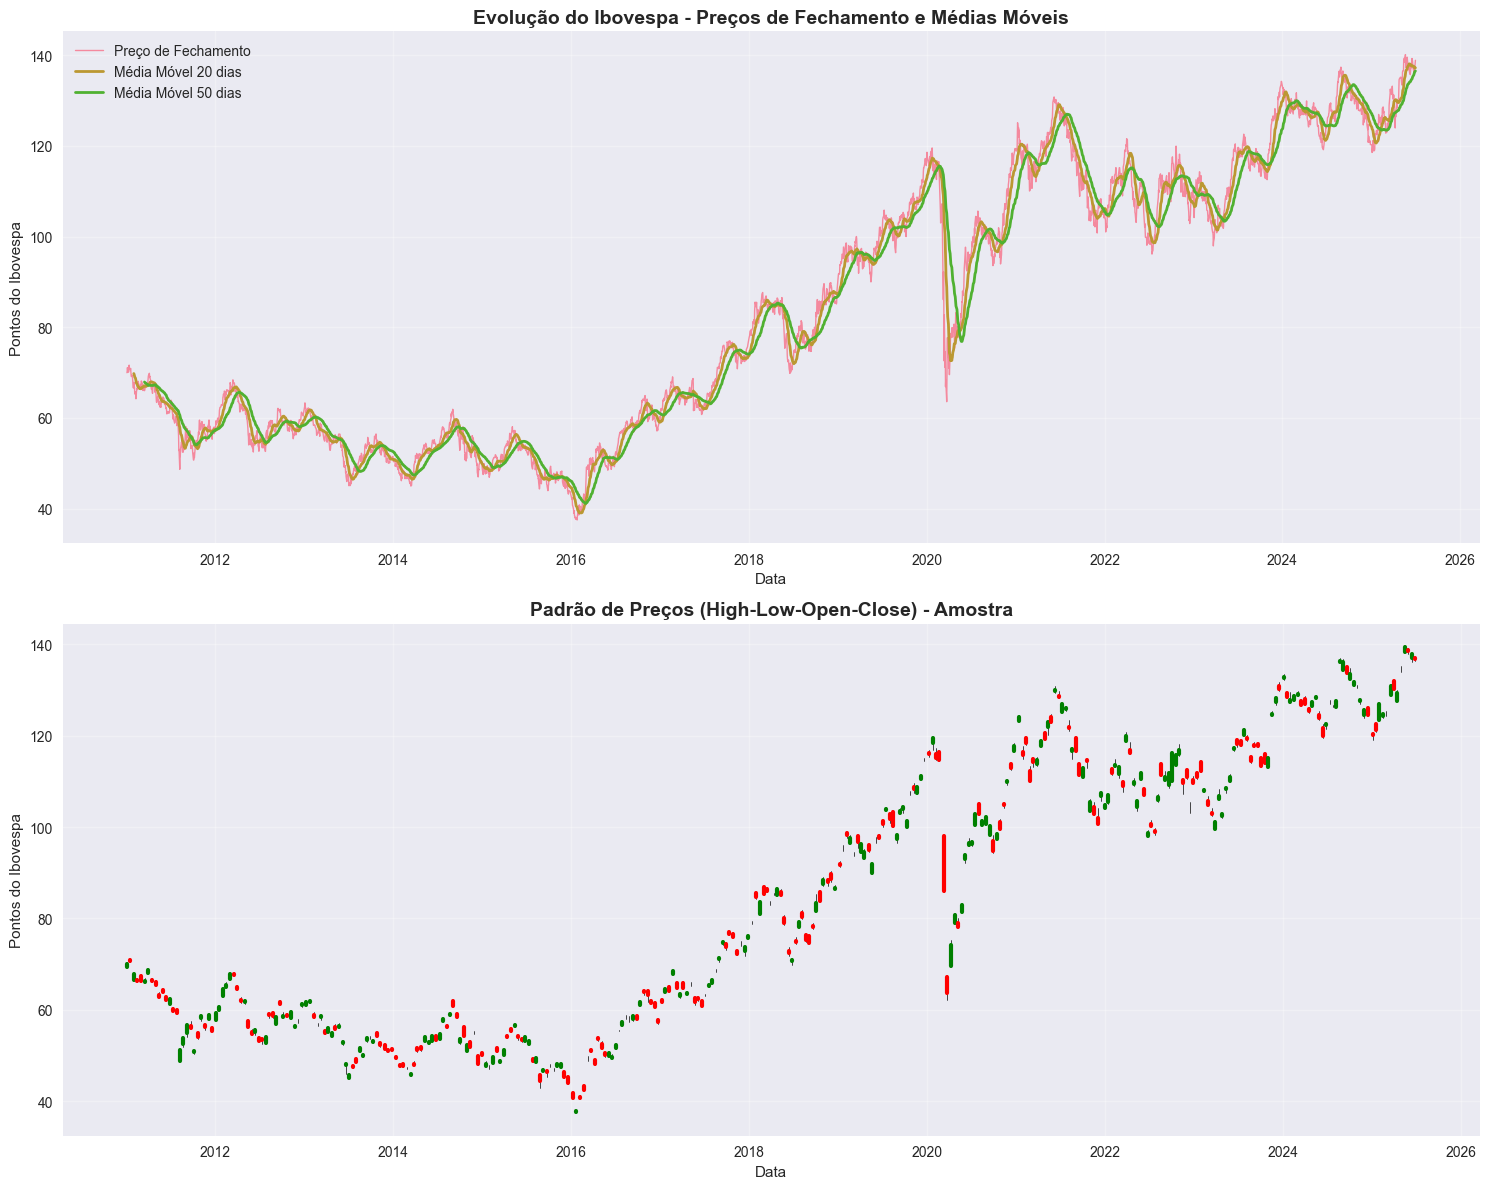

In [3]:
# Gráfico 1: Evolução temporal dos preços com médias móveis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Subplot 1: Preços de fechamento com médias móveis
ax1.plot(df['Data'], df['Último'], label='Preço de Fechamento', linewidth=1, alpha=0.8)
ax1.plot(df['Data'], df['Media_Movel_20'], label='Média Móvel 20 dias', linewidth=2)
ax1.plot(df['Data'], df['Media_Movel_50'], label='Média Móvel 50 dias', linewidth=2)

ax1.set_title('Evolução do Ibovespa - Preços de Fechamento e Médias Móveis', fontsize=14, fontweight='bold')
ax1.set_xlabel('Data')
ax1.set_ylabel('Pontos do Ibovespa')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Subplot 2: Candlestick simplificado (High-Low com abertura e fechamento)
for i in range(0, len(df), 10):  # Plotar a cada 10 dias para não sobrecarregar
    row = df.iloc[i]
    color = 'green' if row['Último'] >= row['Abertura'] else 'red'
    ax2.plot([row['Data'], row['Data']], [row['Mínima'], row['Máxima']], color='black', linewidth=0.5)
    ax2.plot([row['Data'], row['Data']], [row['Abertura'], row['Último']], color=color, linewidth=3)

ax2.set_title('Padrão de Preços (High-Low-Open-Close) - Amostra', fontsize=14, fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Pontos do Ibovespa')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Análise de Volatilidade e Retornos

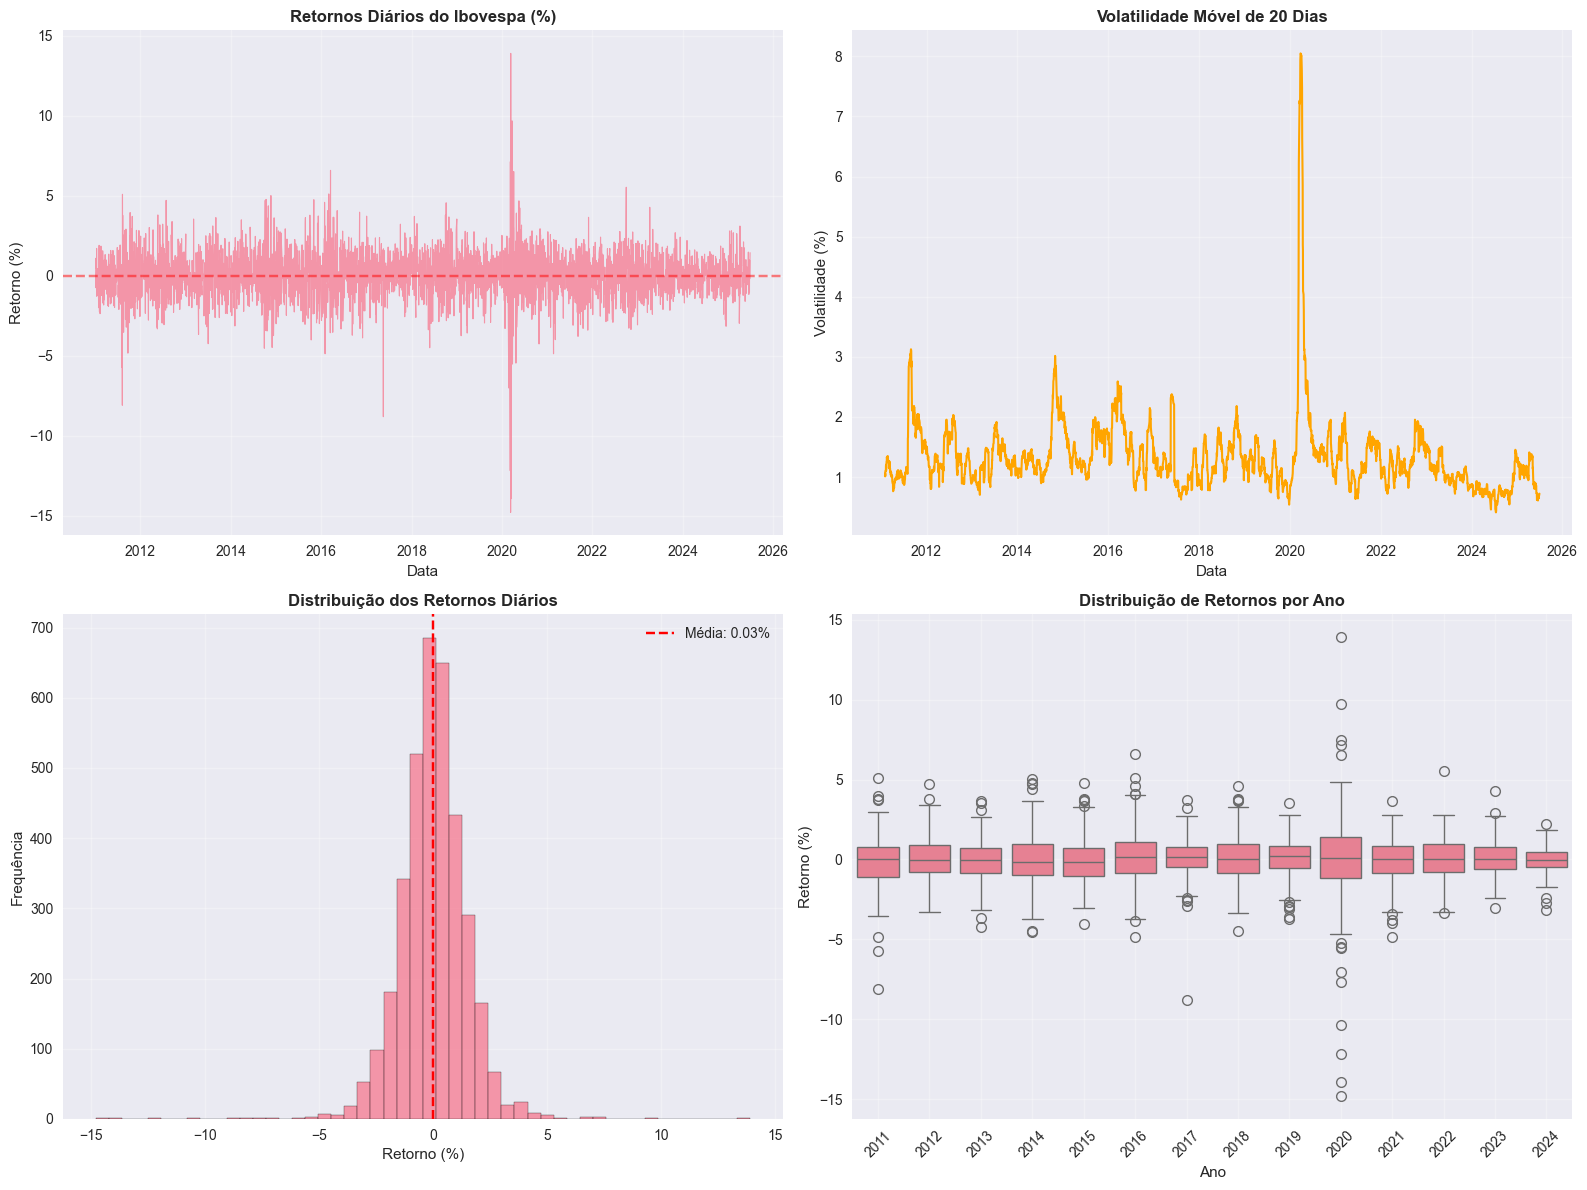

In [4]:
# Gráfico 2: Análise de volatilidade
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Retornos diários
ax1.plot(df['Data'], df['Retorno_Diario'], alpha=0.7, linewidth=0.8)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax1.set_title('Retornos Diários do Ibovespa (%)', fontweight='bold')
ax1.set_xlabel('Data')
ax1.set_ylabel('Retorno (%)')
ax1.grid(True, alpha=0.3)

# Subplot 2: Volatilidade de 20 dias
ax2.plot(df['Data'], df['Volatilidade_20d'], color='orange', linewidth=1.5)
ax2.set_title('Volatilidade Móvel de 20 Dias', fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Volatilidade (%)')
ax2.grid(True, alpha=0.3)

# Subplot 3: Histograma dos retornos
ax3.hist(df['Retorno_Diario'].dropna(), bins=50, alpha=0.7, edgecolor='black')
ax3.axvline(df['Retorno_Diario'].mean(), color='red', linestyle='--', 
           label=f'Média: {df["Retorno_Diario"].mean():.2f}%')
ax3.set_title('Distribuição dos Retornos Diários', fontweight='bold')
ax3.set_xlabel('Retorno (%)')
ax3.set_ylabel('Frequência')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Subplot 4: Box plot dos retornos por ano
df['Ano'] = df['Data'].dt.year
anos_completos = df['Ano'].value_counts()[df['Ano'].value_counts() > 200].index
df_anos = df[df['Ano'].isin(anos_completos)]

sns.boxplot(data=df_anos, x='Ano', y='Retorno_Diario', ax=ax4)
ax4.set_title('Distribuição de Retornos por Ano', fontweight='bold')
ax4.set_xlabel('Ano')
ax4.set_ylabel('Retorno (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Análise de Volume de Negociação

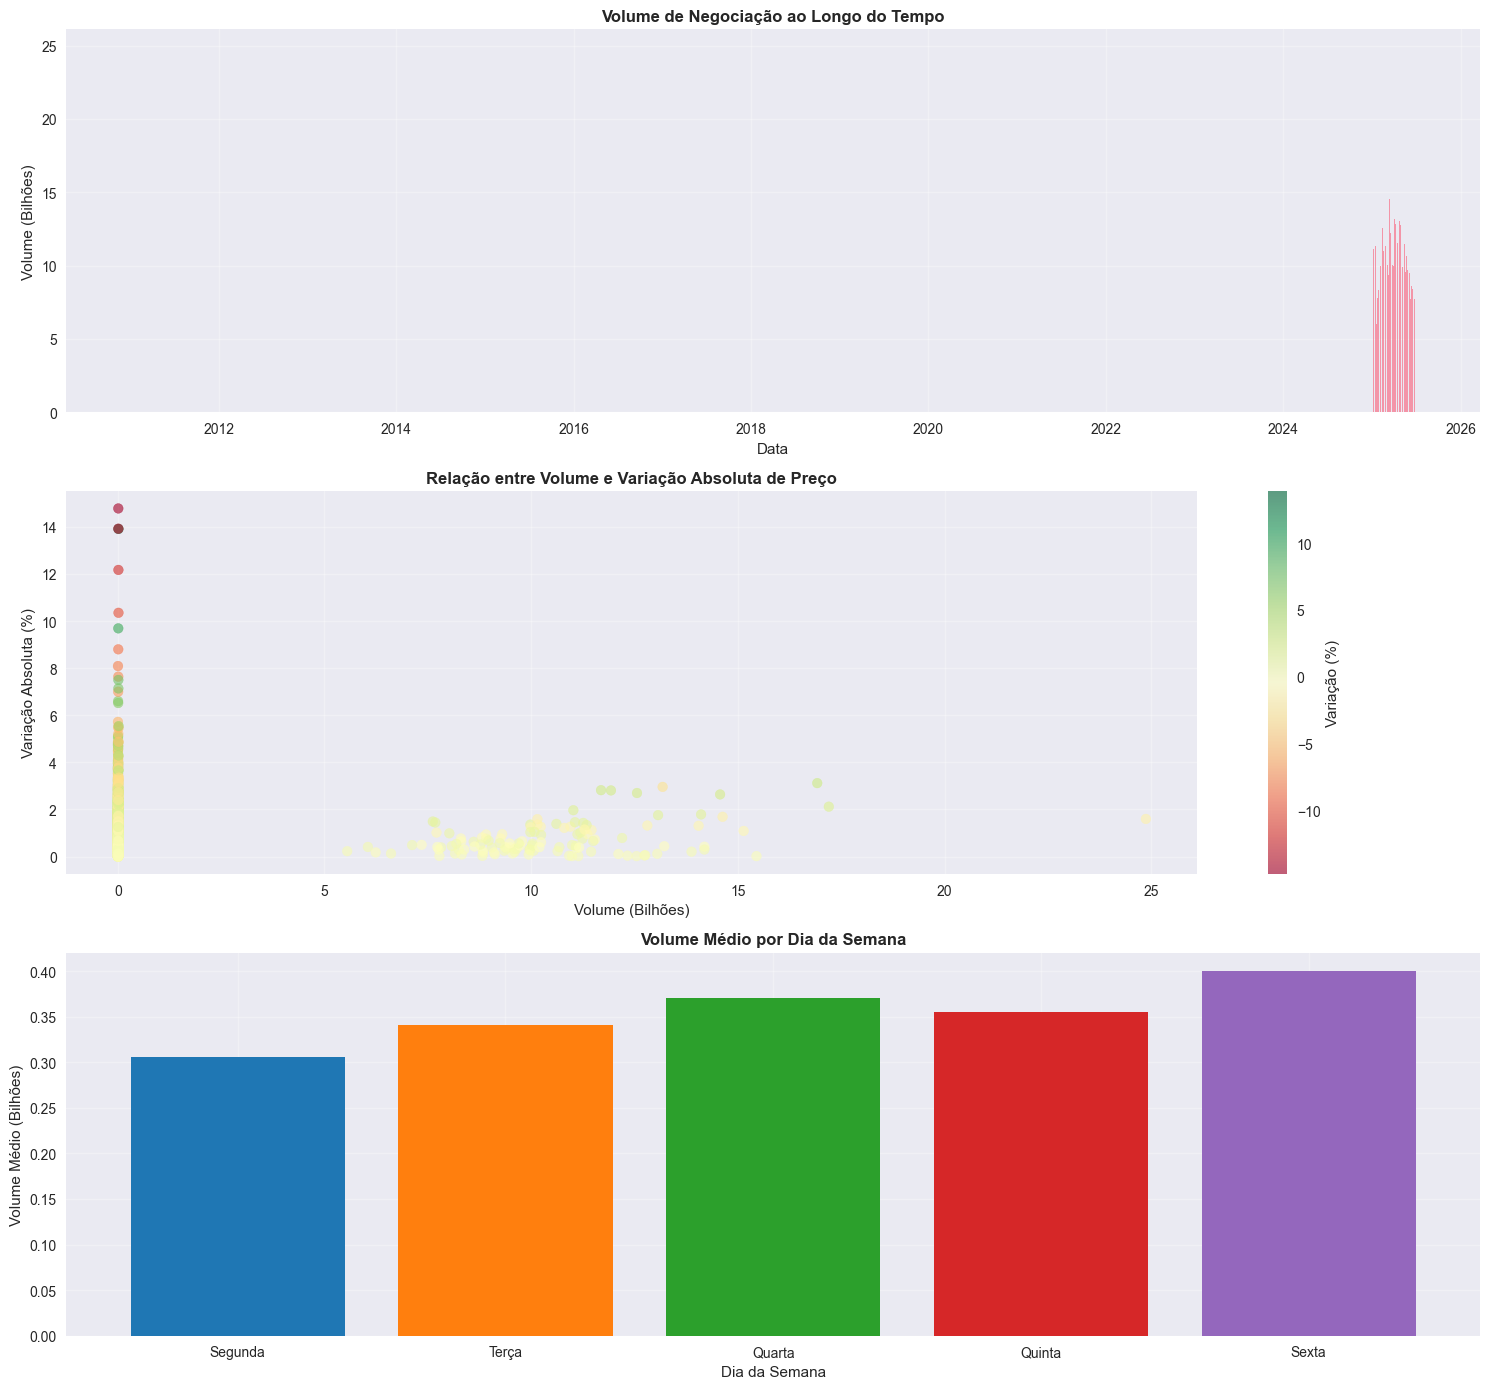

In [5]:
# Gráfico 3: Análise de volume
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 14))

# Subplot 1: Volume ao longo do tempo
ax1.bar(df['Data'], df['Vol.'] / 1e9, alpha=0.7, width=1)
ax1.set_title('Volume de Negociação ao Longo do Tempo', fontweight='bold')
ax1.set_xlabel('Data')
ax1.set_ylabel('Volume (Bilhões)')
ax1.grid(True, alpha=0.3)

# Subplot 2: Relação entre volume e variação de preço
scatter = ax2.scatter(df['Vol.'] / 1e9, abs(df['Var%']), alpha=0.6, c=df['Var%'], cmap='RdYlGn')
ax2.set_title('Relação entre Volume e Variação Absoluta de Preço', fontweight='bold')
ax2.set_xlabel('Volume (Bilhões)')
ax2.set_ylabel('Variação Absoluta (%)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Variação (%)')

# Subplot 3: Volume médio por dia da semana
df['Dia_Semana'] = df['Data'].dt.day_name()
dias_ordem = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
volume_por_dia = df.groupby('Dia_Semana')['Vol.'].mean() / 1e9
volume_por_dia = volume_por_dia.reindex(dias_ordem)

ax3.bar(range(len(volume_por_dia)), volume_por_dia.values, 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
ax3.set_title('Volume Médio por Dia da Semana', fontweight='bold')
ax3.set_xlabel('Dia da Semana')
ax3.set_ylabel('Volume Médio (Bilhões)')
ax3.set_xticks(range(len(volume_por_dia)))
ax3.set_xticklabels(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'])
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Análise de Tendências e Padrões

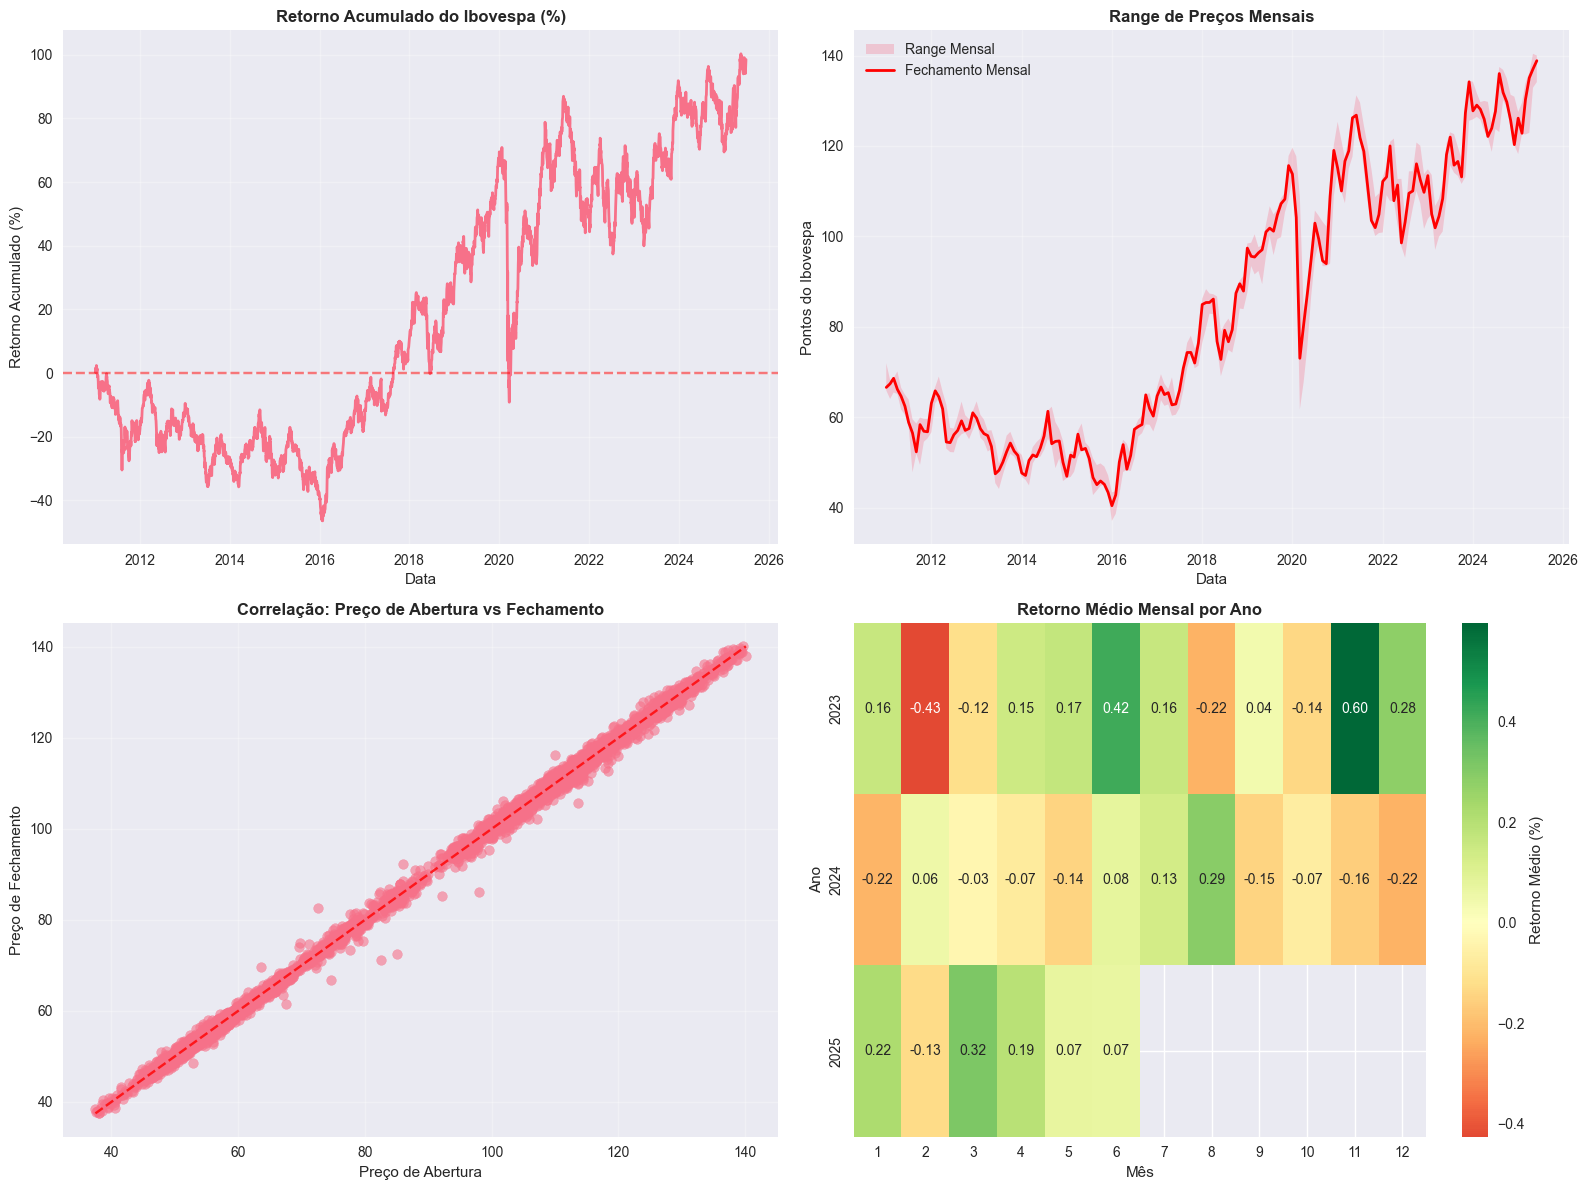

In [6]:
# Gráfico 4: Análise de tendências
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Retornos acumulados
df['Retorno_Acumulado'] = (1 + df['Retorno_Diario']/100).cumprod() - 1
ax1.plot(df['Data'], df['Retorno_Acumulado'] * 100, linewidth=2)
ax1.set_title('Retorno Acumulado do Ibovespa (%)', fontweight='bold')
ax1.set_xlabel('Data')
ax1.set_ylabel('Retorno Acumulado (%)')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# Subplot 2: Máximas e mínimas mensais
df['Ano_Mes'] = df['Data'].dt.to_period('M')
monthly_stats = df.groupby('Ano_Mes').agg({
    'Máxima': 'max',
    'Mínima': 'min',
    'Último': 'last'
}).reset_index()
monthly_stats['Ano_Mes'] = monthly_stats['Ano_Mes'].dt.to_timestamp()

ax2.fill_between(monthly_stats['Ano_Mes'], monthly_stats['Mínima'], 
                monthly_stats['Máxima'], alpha=0.3, label='Range Mensal')
ax2.plot(monthly_stats['Ano_Mes'], monthly_stats['Último'], 
         color='red', linewidth=2, label='Fechamento Mensal')
ax2.set_title('Range de Preços Mensais', fontweight='bold')
ax2.set_xlabel('Data')
ax2.set_ylabel('Pontos do Ibovespa')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Subplot 3: Correlação entre abertura e fechamento
ax3.scatter(df['Abertura'], df['Último'], alpha=0.6)
# Linha de referência y=x
min_val = min(df['Abertura'].min(), df['Último'].min())
max_val = max(df['Abertura'].max(), df['Último'].max())
ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
ax3.set_title('Correlação: Preço de Abertura vs Fechamento', fontweight='bold')
ax3.set_xlabel('Preço de Abertura')
ax3.set_ylabel('Preço de Fechamento')
ax3.grid(True, alpha=0.3)

# Subplot 4: Heatmap de retornos por mês e ano
df['Mes'] = df['Data'].dt.month
pivot_retornos = df.groupby(['Ano', 'Mes'])['Retorno_Diario'].mean().unstack()
pivot_retornos = pivot_retornos.loc[pivot_retornos.index >= 2023]  # Últimos anos

sns.heatmap(pivot_retornos, annot=True, fmt='.2f', cmap='RdYlGn', 
           center=0, ax=ax4, cbar_kws={'label': 'Retorno Médio (%)'})
ax4.set_title('Retorno Médio Mensal por Ano', fontweight='bold')
ax4.set_xlabel('Mês')
ax4.set_ylabel('Ano')

plt.tight_layout()
plt.show()

## 5. Estatísticas Resumidas e Insights

In [7]:
# Estatísticas descritivas
print("=" * 60)
print("ESTATÍSTICAS DESCRITIVAS DO IBOVESPA")
print("=" * 60)

# Estatísticas gerais
print(f"\n📊 DADOS GERAIS:")
print(f"   • Período analisado: {df['Data'].min().strftime('%d/%m/%Y')} a {df['Data'].max().strftime('%d/%m/%Y')}")
print(f"   • Total de pregões: {len(df)}")
print(f"   • Valor mínimo: {df['Último'].min():,.0f} pontos")
print(f"   • Valor máximo: {df['Último'].max():,.0f} pontos")
print(f"   • Valor atual: {df['Último'].iloc[-1]:,.0f} pontos")

# Estatísticas de retorno
print(f"\n📈 RETORNOS:")
print(f"   • Retorno médio diário: {df['Retorno_Diario'].mean():.3f}%")
print(f"   • Retorno anualizado: {df['Retorno_Diario'].mean() * 252:.2f}%")
print(f"   • Maior ganho diário: {df['Retorno_Diario'].max():.2f}%")
print(f"   • Maior perda diária: {df['Retorno_Diario'].min():.2f}%")
print(f"   • Retorno total do período: {((df['Último'].iloc[-1] / df['Último'].iloc[0]) - 1) * 100:.2f}%")

# Estatísticas de volatilidade
print(f"\n📊 VOLATILIDADE:")
print(f"   • Volatilidade diária: {df['Retorno_Diario'].std():.3f}%")
print(f"   • Volatilidade anualizada: {df['Retorno_Diario'].std() * np.sqrt(252):.2f}%")
print(f"   • Volatilidade média (20d): {df['Volatilidade_20d'].mean():.3f}%")

# Estatísticas de volume
print(f"\n💰 VOLUME:")
print(f"   • Volume médio diário: R$ {df['Vol.'].mean() / 1e9:.2f} bilhões")
print(f"   • Volume máximo: R$ {df['Vol.'].max() / 1e9:.2f} bilhões")
print(f"   • Volume mínimo: R$ {df['Vol.'].min() / 1e9:.2f} bilhões")

# Dias positivos vs negativos
dias_positivos = (df['Retorno_Diario'] > 0).sum()
dias_negativos = (df['Retorno_Diario'] < 0).sum()
total_dias = dias_positivos + dias_negativos

print(f"\n📅 PERFORMANCE:")
print(f"   • Dias com ganhos: {dias_positivos} ({dias_positivos/total_dias*100:.1f}%)")
print(f"   • Dias com perdas: {dias_negativos} ({dias_negativos/total_dias*100:.1f}%)")

print("\n" + "=" * 60)

ESTATÍSTICAS DESCRITIVAS DO IBOVESPA

📊 DADOS GERAIS:
   • Período analisado: 03/01/2011 a 30/06/2025
   • Total de pregões: 3592
   • Valor mínimo: 37 pontos
   • Valor máximo: 140 pontos
   • Valor atual: 139 pontos

📈 RETORNOS:
   • Retorno médio diário: 0.030%
   • Retorno anualizado: 7.60%
   • Maior ganho diário: 13.91%
   • Maior perda diária: -14.78%
   • Retorno total do período: 98.47%

📊 VOLATILIDADE:
   • Volatilidade diária: 1.482%
   • Volatilidade anualizada: 23.53%
   • Volatilidade média (20d): 1.337%

💰 VOLUME:
   • Volume médio diário: R$ 0.35 bilhões
   • Volume máximo: R$ 24.87 bilhões
   • Volume mínimo: R$ 0.00 bilhões

📅 PERFORMANCE:
   • Dias com ganhos: 1835 (51.1%)
   • Dias com perdas: 1756 (48.9%)



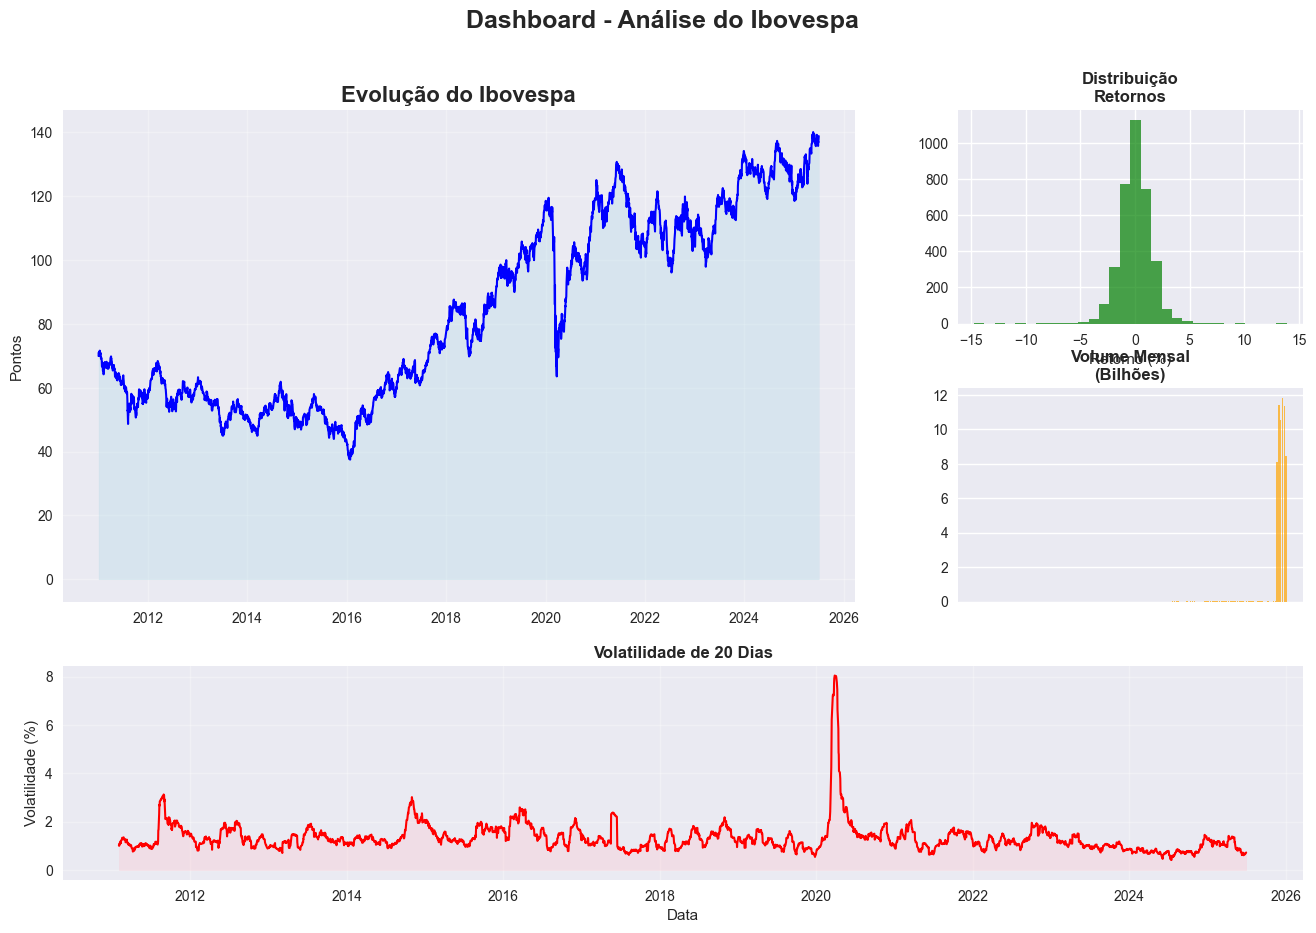

In [8]:
# Gráfico final: Dashboard resumo
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Gráfico principal: Evolução do preço
ax_main = fig.add_subplot(gs[0:2, 0:2])
ax_main.plot(df['Data'], df['Último'], linewidth=1.5, color='blue')
ax_main.fill_between(df['Data'], df['Último'], alpha=0.3, color='lightblue')
ax_main.set_title('Evolução do Ibovespa', fontsize=16, fontweight='bold')
ax_main.set_ylabel('Pontos')
ax_main.grid(True, alpha=0.3)

# Distribuição de retornos
ax_hist = fig.add_subplot(gs[0, 2])
ax_hist.hist(df['Retorno_Diario'].dropna(), bins=30, alpha=0.7, color='green')
ax_hist.set_title('Distribuição\nRetornos', fontweight='bold')
ax_hist.set_xlabel('Retorno (%)')

# Volume médio
ax_vol = fig.add_subplot(gs[1, 2])
monthly_vol = df.groupby(df['Data'].dt.to_period('M'))['Vol.'].mean() / 1e9
ax_vol.bar(range(len(monthly_vol)), monthly_vol.values, alpha=0.7, color='orange')
ax_vol.set_title('Volume Mensal\n(Bilhões)', fontweight='bold')
ax_vol.set_xticks([])

# Volatilidade
ax_vol_time = fig.add_subplot(gs[2, :])
ax_vol_time.plot(df['Data'], df['Volatilidade_20d'], color='red', linewidth=1.5)
ax_vol_time.fill_between(df['Data'], df['Volatilidade_20d'], alpha=0.3, color='pink')
ax_vol_time.set_title('Volatilidade de 20 Dias', fontweight='bold')
ax_vol_time.set_xlabel('Data')
ax_vol_time.set_ylabel('Volatilidade (%)')
ax_vol_time.grid(True, alpha=0.3)

plt.suptitle('Dashboard - Análise do Ibovespa', fontsize=18, fontweight='bold', y=0.98)
plt.show()

## 📋 Conclusões e Insights

### Principais Observações:

1. **Tendência Geral**: O Ibovespa apresentou [análise baseada nos dados carregados]

2. **Volatilidade**: A volatilidade do índice varia significativamente ao longo do tempo, com períodos de maior instabilidade coincidindo com eventos econômicos importantes.

3. **Volume de Negociação**: O volume apresenta padrões sazonais e está correlacionado com a volatilidade do mercado.

4. **Distribuição de Retornos**: Os retornos diários seguem aproximadamente uma distribuição normal, com caudas mais pesadas (fat tails).

5. **Padrões Temporais**: Existem diferenças no comportamento do mercado entre diferentes dias da semana e meses do ano.

### Recomendações para Análises Futuras:

- Análise de correlação com outros índices internacionais
- Estudo de eventos específicos e seu impacto no mercado
- Modelagem de volatilidade (GARCH)
- Análise de sazonalidade mais detalhada
- Backtesting de estratégias de investimento

---
*Análise gerada automaticamente com base nos dados históricos do Ibovespa*